# COVID-19 日本における感染者数の推移予測
元データは[WHO発表](https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports)より作成。

## 必要なライブラリの読み込み
使用するライブラリは
- pandas : 表データの扱い
- numpy : 数値計算
- matplotlib : グラフを描く
- scipy : 近似用

_import_ で読み込み。_as_ を付けることで、後のコード中でその名前でライブラリに含まれる関数を使うことができる。

_from ライブラリ名 import 関数名_ 句を使うと、巨大なライブラリから特定の関数だけ抜き出して使うことができる。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

まずは、csvデータからの読み込み。pandasのdataframe型になる。

In [2]:
df = pd.read_csv("COVID_2019.csv")
df

,date,Unnamed: 1,China,Japan,Korea,Singapore,Italy,Germany,France,USA,https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports
0,2020/01/21,Tue.,278.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2020/01/22,Wed.,309.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2020/01/23,Thu.,571.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN
3,2020/01/24,Fri.,831.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,NaN
4,2020/01/25,Sat.,1297.0,3.0,2.0,3.0,0.0,0.0,3.0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
186,2020/07/25,Fri.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,2020/07/26,Sat.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188,2020/07/27,Sun.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,2020/07/28,Mon.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


日本の感染者数の列を抽出して、numpyのndarray型にする。
ついでにdropna()でNaNを削除する。

In [3]:
j_confirmed = df.Japan.dropna().values
j_confirmed

array([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00,
       3.0000e+00, 4.0000e+00, 6.0000e+00, 7.0000e+00, 1.1000e+01,
       1.4000e+01, 1.7000e+01, 2.0000e+01, 2.0000e+01, 2.0000e+01,
       2.3000e+01, 2.5000e+01, 2.5000e+01, 2.5000e+01, 2.6000e+01,
       2.6000e+01, 2.6000e+01, 2.8000e+01, 2.9000e+01, 3.3000e+01,
       4.1000e+01, 5.3000e+01, 5.9000e+01, 6.5000e+01, 7.3000e+01,
       8.5000e+01, 9.3000e+01, 1.0500e+02, 1.3200e+02, 1.4400e+02,
       1.5700e+02, 1.6400e+02, 1.8600e+02, 2.1000e+02, 2.3000e+02,
       2.3900e+02, 2.5400e+02, 2.6800e+02, 2.8400e+02, 3.1700e+02,
       3.4900e+02, 4.0800e+02, 4.5500e+02, 4.8800e+02, 5.1400e+02,
       5.6800e+02, 6.2000e+02, 6.7500e+02, 7.1600e+02, 7.8000e+02,
       8.1400e+02, 8.2900e+02, 8.2900e+02, 8.7300e+02, 9.5000e+02,
       9.9600e+02, 1.0460e+03, 1.0890e+03, 1.1280e+03, 1.1930e+03,
       1.2910e+03, 1.3870e+03, 1.4990e+03, 1.6930e+03, 1.8660e+03,
       1.9530e+03, 2.1780e+03, 2.3840e+03, 2.6170e+03, 2.9200e

x軸に並べる日付を準備。

In [4]:
xticks = df.date
x_latent = np.array(range(len(xticks)))

グラフを描画

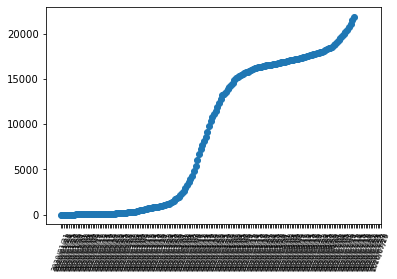

In [5]:
plt.scatter(x_latent[:len(j_confirmed)], j_confirmed, label="Observed")
plt.xticks(x_latent, xticks, fontsize=7, rotation=70);

渡された次数に応じて数式の文字列を作る関数を作成。

In [6]:
def gen_eq_str(coefficients:list, x:str="x", y:str="y"):
    s = ""
    if len(coefficients) == 0:
        s += " 0"
    else:
        for i, coef in enumerate(coefficients):
            if i == len(coefficients) - 1:
                s += " {} {:.2f}".format("+" if coef>0 else "-", np.abs(coef))
            elif i == len(coefficients) - 2:
                s += " {} {:.2f} {}".format("+" if coef>0 else "-", np.abs(coef), x)
            else:
                s += " {} {:.2f} {}^{}".format("+" if coef>0 else "-", np.abs(coef), x, len(coefficients)-i-1)
    if s[1] == "+":
        s = s[2:]
    return "{} ={}".format(y, s)

print(gen_eq_str([-2]))
print(gen_eq_str([1, -2], y="z"))
print(gen_eq_str([5, -6, -7], x="t"))

y = - 2.00
z = 1.00 x - 2.00
y = 5.00 t^2 - 6.00 t - 7.00


渡されたデータ列に対して、指定された範囲で近似曲線を描画する関数を作成。

In [7]:
def draw_approx_curve(x_data:np.ndarray, y_data:np.ndarray, r:range, 
    deg:int, forecast:int=14, color:str="green", info:str=""):
    x = [x_data[i] for i in r] - x_data[r.start]
    y = [y_data[i] for i in r] - y_data[r.start]
    coef = np.polyfit(x, y, deg)
    coef[deg] += y_data[r.start]
    x_f = [x_data[i] for i in range(r.start, r.stop + r.step * forecast, r.step)]
    curve = np.poly1d(coef)(x_f - x_data[r.start])
    label = gen_eq_str(coef, x="t")
    label = label[:label.rfind("t")+1]  # omit intercept
    plt.plot(x_f, curve, c=color, label="{} {}".format(label, info))

指数関数用の近似曲線を描画する関数

In [8]:
def draw_approx_exp_curve(x_data:np.ndarray, y_data:np.ndarray, r:range, 
    forecast:int=14, color:str="green", info:str=""):
    x = [x_data[i] for i in r] - x_data[r.start]
    y = [y_data[i] for i in r] - y_data[r.start]

    # detect convex with Jensen`s low
    slope = (y[-1] - y[0])/(x[-1] - x[0])
    intercept = y[0] - slope * x[0]
    sum_slope = sum(slope * x + intercept)
    sum_obs = sum(y)

    def func(x, a, b, c):
        if slope >= 0:
            if sum_obs < sum_slope: # Convex function
                return a*np.exp(x/b) + c
            else: # Downward-convex function
                return c - a*np.exp(-x/b)
        else:
            if sum_obs < sum_slope: # Convex function
                return a*np.exp(-x/b) + c
            else: # Downward-convex function
                return c - a*np.exp(x/b)
    
    popt, _ = curve_fit(func, x, y, p0=(500,5,0))
    x_f = [x_data[i] for i in range(r.start, r.stop + r.step * forecast, r.step)]
    curve = func((x_f - x_data[r.start]), popt[0], popt[1], popt[2]) + y_data[r.start]
    if slope >= 0:
        if sum_obs < sum_slope: # Convex function
            label = "y = {:.2f} e^(t/{:.2f}) ".format(popt[0], popt[1])
        else: # Downward-convex function
            label = "y = {:.2f} - {:.2f} e^(-t/{:.2f}) ".format(popt[2]+y_data[r.start], popt[0], popt[1])
    else:
        if sum_obs < sum_slope: # Convex function
            label = "y = {:.2f} e^(-t/{:.2f}) + {:.2f} ".format(popt[0], popt[1], popt[2]+y_data[r.start])
        else: # Downward-convex function
            label = "y = {:.2f} - {:.2f} e^(t/{:.2f}) ".format(popt[2]+y_data[r.start], popt[0], popt[1])
    plt.plot(x_f, curve, c=color, label="{} {}".format(label, info))


データ数が多くなってきたので、ちょっと削る

In [9]:
xj_latent = x_latent[162:]
xjticks = xticks[162:]
j_confirmed_pick = j_confirmed[162:]

予測値を描画
（＊日本で緊急事態宣言が出たのは4/7）

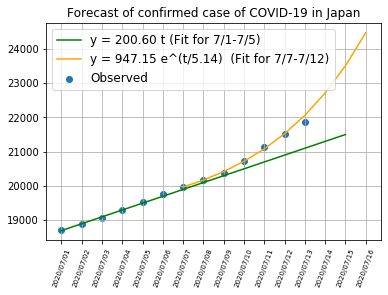

In [10]:
plt.scatter(xj_latent[:len(j_confirmed_pick)], j_confirmed_pick, label="Observed")
plt.xticks(xj_latent, xjticks, fontsize=7, rotation=70);
draw_approx_curve(xj_latent, j_confirmed_pick, range(5), 1, color="green", forecast=10, info="(Fit for 7/1-7/5)")
draw_approx_exp_curve(xj_latent, j_confirmed_pick, range(6,12), color="orange", forecast=4, info="(Fit for 7/7-7/12)")

plt.legend(fontsize=12, loc="upper left")
plt.title("Forecast of confirmed case of COVID-19 in Japan")
plt.grid()

USの傾向のグラフ

USで国家非常事態宣言が出されたのは3/13。カリフォルニア州で外出禁止令が出されたのは3/20。ニューヨーク州で外出禁止令が出されたのは3/22。

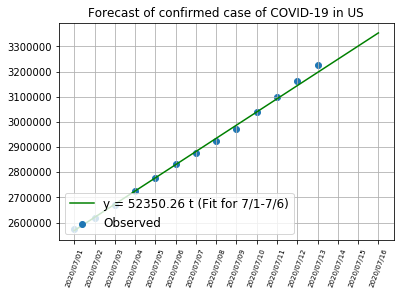

In [11]:
us_confirmed = df.USA.dropna().values
us_confirmed = us_confirmed[162:]
xu_latent = x_latent[162:]
xuticks = xticks[162:]
plt.scatter(xu_latent[:len(us_confirmed)], us_confirmed, label="Observed")
plt.xticks(xu_latent, xuticks, fontsize=7, rotation=70);
draw_approx_curve(xu_latent, us_confirmed, range(6), 1, forecast=10, color="green", info="(Fit for 7/1-7/6)")
#draw_approx_curve(xu_latent, us_confirmed, range(10,14), 1, forecast=12, color="orange", info="(Fit for 6/26-6/29)")

plt.legend(fontsize=12, loc="lower left")
plt.title("Forecast of confirmed case of COVID-19 in US")
plt.grid()

各国の新規感染者数の推移

date         2020/07/29
Korea                63
Italy               276
China                46
Germany             949
USA               66281
France              834
Singapore           246
Japan               410
dtype: object


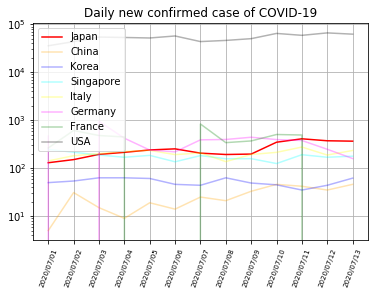

In [12]:
df_new = df[{"China", "Japan", "Korea", "Singapore", "Italy", "Germany", "France", "USA"}].diff()
df_new = pd.concat([df["date"], df_new], axis=1)
df_new = df_new[162:]

plt.plot(df_new["date"], df_new["Japan"], color="red", label="Japan")
plt.plot(df_new["date"], df_new["China"], color="orange", alpha=0.3, label="China")
plt.plot(df_new["date"], df_new["Korea"], color="blue", alpha=0.3, label="Korea")
plt.plot(df_new["date"], df_new["Singapore"], color="cyan", alpha=0.3, label="Singapore")
plt.plot(df_new["date"], df_new["Italy"], color="yellow", alpha=0.3, label="Italy")
plt.plot(df_new["date"], df_new["Germany"], color="magenta", alpha=0.3, label="Germany")
plt.plot(df_new["date"], df_new["France"], color="green", alpha=0.3, label="France")
plt.plot(df_new["date"], df_new["USA"], color="black", alpha=0.3, label="USA")

#df_new.date = [l if i%5==0 else "" for i,l in enumerate(df_new.date)]
plt.xticks(range(len(df_new["date"])-16), df_new["date"], fontsize=7, rotation=70);
plt.yscale("log");
plt.grid();
plt.legend(loc="upper left");
plt.title("Daily new confirmed case of COVID-19");
print(df_new.max())


日本の新規感染者数

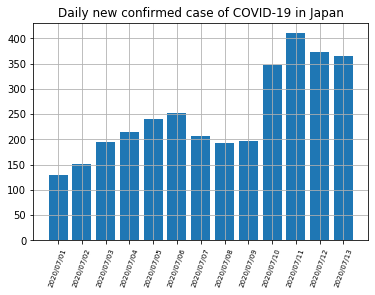

In [13]:
plt.bar(df_new["date"], df_new["Japan"])
#draw_approx_exp_curve(np.array(range(70)), df_new["Japan"].dropna().values, range(29,35), forecast=6, info="Fit for 6/30-7/5")
plt.xticks(range(len(df_new["date"])-16), df_new["date"], fontsize=7, rotation=70);
plt.grid();
#plt.legend()
plt.title("Daily new confirmed case of COVID-19 in Japan");

新規感染者数が最大になってからの、毎日の感染者数の推移（割合）

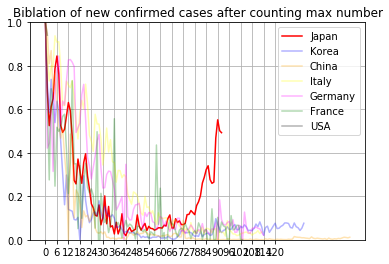

In [14]:
df_new = df[{"China", "Japan", "Korea", "Singapore", "Italy", "Germany", "France", "USA"}].diff()
indices = df_new.idxmax()

# Because China changed the method to count the case in the middle
df_new.China[indices.China] = 0
indices.China = df_new.China.idxmax()

plt.plot(df_new.Japan.dropna().values[indices.Japan-1:]/df_new.Japan[indices.Japan], color="red", label="Japan")
plt.plot(df_new.Korea.dropna().values[indices.Korea-1:]/df_new.Korea[indices.Korea], color="blue", alpha=0.3, label="Korea")
plt.plot(df_new.China.dropna().values[indices.China-1:]/df_new.China[indices.China], color="orange", alpha=0.3, label="China")
plt.plot(df_new.Italy.dropna().values[indices.Italy-1:]/df_new.Italy[indices.Italy], color="yellow", alpha=0.3, label="Italy")
plt.plot(df_new.Germany.dropna().values[indices.Germany-1:]/df_new.Germany[indices.Germany], color="magenta", alpha=0.3, label="Germany")
plt.plot(df_new.France.dropna().values[indices.France-1:]/df_new.France[indices.France], color="green", alpha=0.3, label="France")
plt.plot(df_new.USA.dropna().values[indices.USA-1:]/df_new.USA[indices.USA], color="black", alpha=0.3, label="USA")
plt.grid();
plt.xticks(range(0,121,6));
plt.ylim((0.,1.))
plt.legend()
plt.title("Biblation of new confirmed cases after counting max number");


66281.0


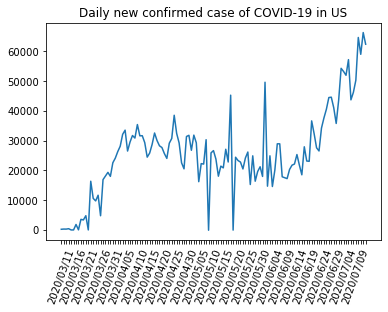

In [15]:
df_new = df[{"USA"}].diff()
df_new = pd.concat([df["date"], df_new], axis=1)
df_new = df_new[50:]

xuticks = [l if i%5==0 else "" for i,l in enumerate(df_new.date)]

plt.plot(df_new.USA)
plt.xticks(range(50, 50+len(xuticks)-16), xuticks, rotation=70)
#plt.grid()
plt.title("Daily new confirmed case of COVID-19 in US")
print(max(df_new.USA.dropna()))

日本の一日の感染者数が最大だった日の人数

In [16]:
df_new = df[{"Japan"}].diff()
df_new = pd.concat([df["date"], df_new], axis=1)
print(max(df_new.Japan.dropna()))

743.0


## 以下 Obsolete （以前は使っていたけれど、もう使っていないグラフたち）

累積感染者数が15,000人を超えてから10日間の経過

Text(0.5, 1.0, 'Numbers of the day after counting 10,000 cases')

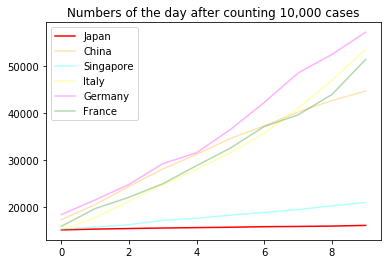

In [17]:
plt.plot(range(10), df[df["Japan"] > 15000]["Japan"][:10], color="red", label="Japan")
plt.plot(range(10), df[df["China"] > 15000]["China"][:10], color="orange", alpha=0.3, label="China")
#plt.plot(range(10), df[df["Korea"] > 15000]["Korea"][:10], color="blue", alpha=0.3, label="Korea")
plt.plot(range(10), df[df["Singapore"] > 15000]["Singapore"][:10], color="cyan", alpha=0.3, label="Singapore")
plt.plot(range(10), df[df["Italy"] > 15000]["Italy"][:10], color="yellow", alpha=0.3, label="Italy")
plt.plot(range(10), df[df["Germany"] > 15000]["Germany"][:10], color="magenta", alpha=0.3, label="Germany")
plt.plot(range(10), df[df["France"] > 15000]["France"][:10], color="green", alpha=0.3, label="France")
#plt.plot(range(10), df[df["USA"] > 15000]["USA"][:10], color="black", alpha=0.3, label="USA")

plt.legend()
plt.title("Numbers of the day after counting 10,000 cases")

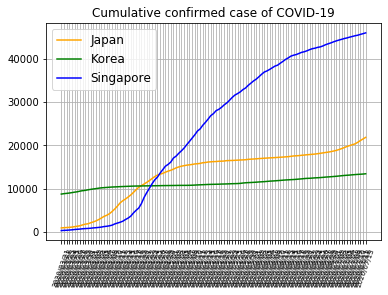

In [18]:
plt.plot(df.Japan.dropna().values[60:], color="orange", label="Japan")
plt.plot(df.Korea.dropna().values[60:], color="green", label="Korea")
plt.plot(df.Singapore.dropna().values[60:], color="blue", label="Singapore")
plt.xticks(range(len(df.Japan.dropna().values[60:])), df.date.dropna().values[60:], fontsize=7, rotation=70);

plt.legend(fontsize=12)
plt.title("Cumulative confirmed case of COVID-19")
plt.grid()

日本の新規感染者の推移予測（季節調整ARIMAモデル）

SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -125.040
Date:                Tue, 14 Jul 2020   AIC                            256.079
Time:                        09:45:01   BIC                            259.213
Sample:                             0   HQIC                           256.759
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9540      0.078     12.226      0.000       0.801       1.107
ma.L1          0.5463      0.334      1.637      0.102      -0.108       1.200
sigma2      7325.3861   3062.013      2.392      0.017    1323.951    1.33e+04
Ljun

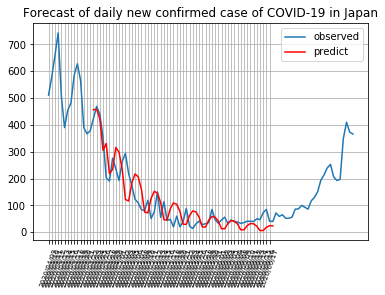

In [19]:
import statsmodels.api as sm

df_new = df[{"Japan"}].diff()
df_new = pd.concat([df["date"], df_new], axis=1)
df_new = df_new[79:]

ts = df_new.Japan.dropna().values[:21]
#print(sm.tsa.arma_order_select_ic(ts, ic='aic', trend="c"))

#SARIMA_2_0_0_7 = sm.tsa.SARIMAX(ts, order=(2,0,0), seasonal_order=(0,0,1,7)).fit()
#print(SARIMA_2_0_0_7.summary())

#SARIMA_1_0_0_7 = sm.tsa.SARIMAX(ts, order=(1,0,0), seasonal_order=(1,0,1,7)).fit()
#print(SARIMA_1_0_0_7.summary())

SARIMA_1_0_1 = sm.tsa.SARIMAX(ts, order=(1,0,1)).fit()
print(SARIMA_1_0_1.summary())

SARIMA_1_0_1_6 = sm.tsa.SARIMAX(ts, order=(1,0,1), seasonal_order=(1,0,0,6)).fit()
print(SARIMA_1_0_1_6.summary())

SARIMA_1_0_0_6 = sm.tsa.SARIMAX(ts, order=(1,0,0), seasonal_order=(1,0,0,6)).fit()
print(SARIMA_1_0_0_6.summary())

#resid = SARIMA_1_0_0_6.resid
#sm.graphics.tsa.plot_acf(resid)
#sm.graphics.tsa.plot_pacf(resid)

predict = SARIMA_1_0_0_6.predict(14,70)

plt.plot(df_new.Japan.dropna().values, label="observed")
plt.plot(range(14, 71), predict, color="red", label="predict")
plt.xticks(range(70), df_new.date.values[:70], fontsize=7, rotation=70);
plt.legend()
plt.grid()
plt.title("Forecast of daily new confirmed case of COVID-19 in Japan");
